<a href="https://colab.research.google.com/github/harshitadd/AI4BharatTranslation/blob/main/BHP_CDCWT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install shap 
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math

In [2]:
def global_data():
  boston_dataset = load_boston()
  df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
  df['MEDV'] = boston_dataset.target
  df=df.sample(frac=1) #shuffling the dataframe to remove sequentially identical data
  return df 


def make_dataset(df, start, end, drop_columns=[]): 
  
  df=df.drop(columns=drop_columns)
  df=df[start:end]
  X = df.loc[:, df.columns != 'MEDV']
  y = df.loc[:, df.columns == 'MEDV']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
  
  #Normalizing data 
  mean = X_train.mean(axis=0)
  std = X_train.std(axis=0)
  X_train = (X_train - mean) / std
  X_test = (X_test - mean) / std
  
  return X_train, X_test, y_train, y_test

In [3]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0021)

In [4]:
df = global_data()

In [5]:
df.keys()  

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [6]:
K = 13 

In [7]:
model1 = Sequential(name='Client_1')
model1.add(Dense(128, input_shape=(13, ), activation='relu', name='client_dense_1'))
model1.add(Dense(64, activation='relu', name='dense_2'))
model1.add(Dense(1, activation='linear', name='dense_output'))
model1.compile(optimizer=opt, loss='mse', metrics=['mae'])

In [8]:
#Custom callback for deactivating feature specific neurons - for Client 1 we are assuming : 0:3 are the only active input neurons. 
class My_Callback(tf.keras.callbacks.Callback):

    def __init__(self, m):
      self.m = m
    def on_epoch_begin(self,epoch,logs={}):
      return

    def on_epoch_end(self, epoch, logs={}):
      new_weights_dense = list(self.model.layers[0].weights[0][:self.m].numpy())
      new_weights_bias = np.zeros((128,))
      
      for i in range(K-self.m):
        new_weights_dense.append(np.zeros((128)))
        
      dropout_layer_weights=[]
      dropout_layer_weights.append(np.array(new_weights_dense))
      dropout_layer_weights.append(np.array(new_weights_bias)) 

      for weights in self.model.weights[2:]:
                dropout_layer_weights.append(weights.numpy())
      self.model.set_weights(dropout_layer_weights)   
      return self.m

In [9]:
model2 = Sequential(name='Client_2')
model2.add(Dense(128, input_shape=(13, ), activation='relu', name='client2_dense_1'))
model2.add(Dense(64, activation='relu', name='dense_2'))
model2.add(Dense(1, activation='linear', name='dense_output'))
model2.compile(optimizer=opt, loss='mse', metrics=['mae'])


In [10]:
class My_NEWCallback(tf.keras.callbacks.Callback):

    def __init__(self, m):
      self.m = m
    def on_epoch_begin(self,epoch,logs={}):
      return

    def on_epoch_end(self, epoch, logs={}):
      new_weights_dense=[]
  
      new_weights_dense = list(self.model.layers[0].weights[0][:self.m].numpy())
      new_weights_bias = np.zeros((128,))
      
      for i in range(K-self.m):
        new_weights_dense.append(np.zeros((128)))

      new_weights_bias = np.zeros((128,))
      
      dropout_layer_weights=[]
      dropout_layer_weights.append(np.array(new_weights_dense))
      dropout_layer_weights.append(np.array(new_weights_bias)) 

      for weights in self.model.weights[2:]:
                dropout_layer_weights.append(weights.numpy())
      
      self.model.set_weights(dropout_layer_weights)   
      return self.m 

In [11]:
client_models = [model1,model2]

In [12]:
# model_features = {model1:['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE'], 
#                   model2:['DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']}   # No Overlap Case 
# model_features = {model1: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','LSTAT','PTRATIO','TAX'],
#                   model2: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD','LSTAT','PTRATIO','B']}  # Partial Overlap 
model_features = {model1:['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT'],
                 model2:['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']} #Complete Overlap

#Comparison with CDFL - Partial Overlap Case 

In [13]:
m_mapping = {model1:len(model_features[model1]), model2: len(model_features[model2])}

In [14]:
def make_CDFL_client_data(df=df,client_models=client_models):
  client_datasets={}  #Client Name mapped with full dataset - needs to separated into labels and training set 
  for client in client_models:
    print(client.name)
    temp = df 
    drop_columns = [x for x in df.keys() if x not in model_features[client] and x!='MEDV']
    temp=temp.drop(columns=drop_columns)
    X = temp.loc[:, temp.columns != 'MEDV']
    y = temp.loc[:, temp.columns == 'MEDV']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    #Normalizing data 
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    for i in range(len(drop_columns)):
      X_train[drop_columns[i]]=0.0   
    for i in range(len(drop_columns)):
      X_test[drop_columns[i]]=0.0
    
    client_datasets[client]=X_train, X_test, y_train, y_test
  
  return client_datasets

In [15]:
## CDCWT 
## Making the federated iteration loop 

client_datasets=make_CDFL_client_data()
import time
original_weights = {} 
def run_federated_iterations(iterations, visualize):
  k=0 

  global_losses=[]
  client_losses=[]
  checked=0

  for i in range(iterations):
    j=0
    start_time = time.time()
    c=0
    for ctr in range(len(client_models)):    
      X_train,X_test, y_train, y_test = client_datasets[client_models[ctr]]
      X_train=X_train[k:k+2]
      y_train=y_train[k:k+2]
      k+=2
      # print('These are preserved weights - ', original_weights[client_models[ctr]][0])  
      # original_weights[client_models[ctr]] = client_models[ctr].get_weights()  # Will be used to reconstruct weights before transferring 

      # Before setting weights of the next model with the weights of the current model - the zeroed weights of the current model ( because of CD ) are replaced by its original weights before they were zeroed 
      if ctr == 1: 
        neighbour = 0
      else:
        neighbour = 1  
      # try:
      # # client_models[ctr-1].get_weights() # Preceeding clients weights - that are actually zeroed 
      # Reconstructed_weights 
      n = m_mapping[client_models[neighbour]] #Take the neighbour's weights and reconstruct the weights that would have been used had the weights not been zeroed 
      m = m_mapping[client_models[ctr]]
      reconstructed_weights = []
      reconstructed_first_layer_weights = []
      original_weights[client_models[ctr]] = client_models[ctr].get_weights()  # Will be used to reconstruct weights before transferring - Original Weights of the model to which new weights are going to be transferred
      original_initial_layer_weights = original_weights[client_models[ctr]][0]
      reconstructed_first_layer_weights.append(np.vstack((np.asarray(client_models[neighbour].weights[0][0:n]),np.asarray(original_initial_layer_weights[n:]))))
      print(np.shape(original_initial_layer_weights))
      reconstructed_first_layer_weights = np.reshape(reconstructed_first_layer_weights, (K,128))
      reconstructed_weights.append(np.asarray(reconstructed_first_layer_weights))
      for i in range(1,len(client_models[ctr].weights)):
        reconstructed_weights.append(client_models[ctr].weights[i].numpy())
      client_models[ctr].set_weights(reconstructed_weights)  # Here the reconstructed weights will be transferred 
    # except:
      #   print('Failed for ' + str(client_models[ctr].name))

      client_models[ctr].fit(X_train, y_train, epochs=1, validation_split=0.05, shuffle=True, callbacks=None,verbose=0) # For Complete Overlap 
      # client_models[ctr].fit(X_train, y_train, epochs=1, validation_split=0.05, shuffle=True, callbacks=callbacks[j],verbose=0) # For No Overlap/Partial Overlap 
      # print('Weights right after training - ', client_models[ctr].weights[0])

      j+=1
      res = client_models[ctr].evaluate(X_test,y_test)
      client_losses.append(res[0])

      # if(visualize==True):
      #   explainer = shap.DeepExplainer(client_models[ctr], X_train[:50].values)
      #   shap_values = explainer.shap_values(X_test[:50].values)
      #   shap.summary_plot(shap_values, X_test, plot_type='bar',show=True)

  total_time = time.time() - start_time
  return global_losses, total_time, client_losses

Client_1
Client_2


In [16]:
client_models = [model1,model2]
callbacks = [My_Callback(m = len(model_features[model1])),My_NEWCallback(m = len(model_features[model2]))]

In [17]:
losses = run_federated_iterations(90,visualize=False)

(13, 128)
4/4 [==============================] - 0s 4ms/step - loss: 553.6288 - mae: 21.6741
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 541.3972 - mae: 21.3773
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 549.0856 - mae: 21.5533
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 536.9901 - mae: 21.2845
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 544.5245 - mae: 21.4416
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 532.3897 - mae: 21.1779
(13, 128)
4/4 [==============================] - 0s 2ms/step - loss: 540.2966 - mae: 21.3377
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 527.5452 - mae: 21.0667
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 535.6791 - mae: 21.2302
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 522.5699 - mae: 20.9489
(13, 128)
4/4 [==============================] - 0s 3ms/step - loss: 5

In [22]:
c1=[]
c2=[]

for i in range(len(losses[2])):
  if i%2:
    c1.append(losses[2][i])
  else:
    c2.append(losses[2][i])
  

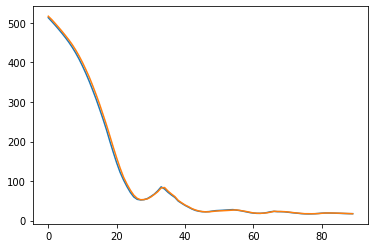

In [ ]:
plt.plot(c1, label = 'Complete  Overlap')
plt.plot(c2)

In [ ]:
plt.plot(c1, label = 'Complete  Overlap')
plt.plot(c2)

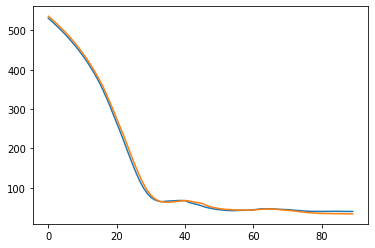

In [ ]:
plt.plot(c1, label = 'Partial Overlap')
plt.plot(c2)

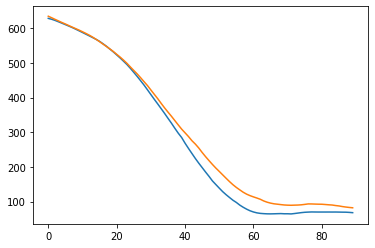

In [19]:
plt.plot(c1, label = 'Partial Overlap')
plt.plot(c2)

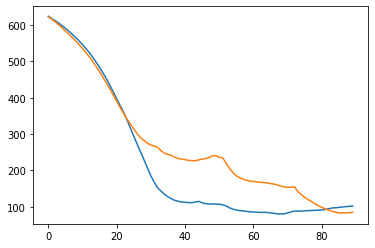

In [ ]:
plt.plot(c1, label = 'No Overlap')
plt.plot(c2)

In [20]:
import pickle
with open('BHP_CDWCT_Complete_Overlap_with_Reconstruction.bin','wb') as file:
  pickle.dump(losses,file)